<a href="https://colab.research.google.com/github/tibayo1/DL-Lung-Sounds/blob/master/C_Lung_Sounds_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries Needed. 

In [ ]:
pip install pysoundfile

In [ ]:
import os
import matplotlib.pyplot as plt

#for loading and visualizing audio files
import librosa as lb
import librosa.display
import pandas as pd
import soundfile as sf
import numpy as np

#to play audio
import IPython.display as ipd


Importing the Dataset from kaggle

Source: [Respiratory Sound Database](https://www.kaggle.com/vbookshelf/respiratory-sound-database)


In [ ]:
import json

# read file
with open('/content/kaggle.json', 'r') as myfile:
    data=myfile.read()
# parse file
obj = json.loads(data)
#get username and key
kaggle_key = str(obj['key'])
kaggle_username = str(obj['username'])


In [ ]:
import os

# parse file
obj = json.loads(data)

os.environ['KAGGLE_USERNAME'] = kaggle_username # username from the json file
os.environ['KAGGLE_KEY'] = kaggle_key # key from the json file
!kaggle datasets download -d "vbookshelf/respiratory-sound-database" # api copied from kaggle



100% 3.67G/3.69G [01:34<00:00, 28.3MB/s]
100% 3.69G/3.69G [01:35<00:00, 41.7MB/s]


In [ ]:
#unzip the folder downloaded from kaggle
!unzip 'respiratory-sound-database.zip'

Archive:  respiratory-sound-database.zip
  inflating: Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Al_sc_Meditron.txt  
  inflating: Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Al_sc_Meditron.wav  
  inflating: Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Pr_sc_Meditron.txt  
  inflating: Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Pr_sc_Meditron.wav  
  inflating: Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/102_1b1_Ar_sc_Meditron.txt  
  inflating: Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/102_1b1_Ar_sc_Meditron.wav  
  inflating: Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/103_2b2_Ar_mc_LittC2SE.txt  
  inflating: Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/103_2b2_Ar_mc_LittC2SE.wav  
  inflating: Respiratory_Sound_

List Directories available in the Datasets

In [ ]:
path = "/content/respiratory_sound_database/Respiratory_Sound_Database"
os.listdir(path)

['filename_format.txt',
 'patient_diagnosis.csv',
 'filename_differences.txt',
 'audio_and_txt_files']

**Pateint Diagnosis**

In [ ]:
patient_data=pd.read_csv('/content/respiratory_sound_database/Respiratory_Sound_Database/patient_diagnosis.csv',
                         names=['pid','disease'])
patient_data.head()

,pid,disease
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI


In [ ]:
path='/content/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files/'
files=[s.split('.')[0] for s in os.listdir(path) if '.txt' in s]

def getFilenameInfo(file):
    return file.split('_')

files_data=[]
for file in files:
    data=pd.read_csv(path + file + '.txt',sep='\t',names=['start','end','crackles','weezels'])
    name_data=getFilenameInfo(file)
    data['pid']=name_data[0]
    data['mode']=name_data[-2]
    data['filename']=file
    files_data.append(data)
files_df=pd.concat(files_data)
files_df.reset_index()
files_df.head()

,start,end,crackles,weezels,pid,mode,filename
0,0.689,1.732,0,0,130,mc,130_2b3_Al_mc_AKGC417L
1,1.732,4.042,1,0,130,mc,130_2b3_Al_mc_AKGC417L
2,4.042,6.339,1,0,130,mc,130_2b3_Al_mc_AKGC417L
3,6.339,8.542,1,0,130,mc,130_2b3_Al_mc_AKGC417L
4,8.542,10.744,1,0,130,mc,130_2b3_Al_mc_AKGC417L


In [ ]:
#Converting the pid from the files to the same data type int32 as patient_data

patient_data.pid=patient_data.pid.astype('int32')
files_df.pid=files_df.pid.astype('int32')


In [ ]:
data=pd.merge(files_df,patient_data,on='pid')
data.head(10)

,start,end,crackles,weezels,pid,mode,filename,disease
0,0.689,1.732,0,0,130,mc,130_2b3_Al_mc_AKGC417L,COPD
1,1.732,4.042,1,0,130,mc,130_2b3_Al_mc_AKGC417L,COPD
2,4.042,6.339,1,0,130,mc,130_2b3_Al_mc_AKGC417L,COPD
3,6.339,8.542,1,0,130,mc,130_2b3_Al_mc_AKGC417L,COPD
4,8.542,10.744,1,0,130,mc,130_2b3_Al_mc_AKGC417L,COPD
5,10.744,12.958,1,0,130,mc,130_2b3_Al_mc_AKGC417L,COPD
6,12.958,14.875,1,0,130,mc,130_2b3_Al_mc_AKGC417L,COPD
7,14.875,16.946,1,0,130,mc,130_2b3_Al_mc_AKGC417L,COPD
8,16.946,19.156,1,0,130,mc,130_2b3_Al_mc_AKGC417L,COPD
9,0.042,1.785,1,0,130,mc,130_2p5_Pr_mc_AKGC417L,COPD


In [ ]:
os.makedirs('csv_data')
data.to_csv('csv_data/data.csv',index=False)

In [ ]:

def getPureSample(raw_data,start,end,sr=22050):
    '''
    Takes a numpy array and spilts its using start and end args
    
    raw_data=numpy array of audio sample
    start=time
    end=time
    sr=sampling_rate
    mode=mono/stereo
    
    '''
    max_ind = len(raw_data) 
    start_ind = min(int(start * sr), max_ind)
    end_ind = min(int(end * sr), max_ind)
    return raw_data[start_ind: end_ind]

In [ ]:
for index,row in data.iterrows():
    print("Index ->",index)
    print("Data->\n",row)
    break

Index -> 0
Data->
 start                        0.689
end                          1.732
crackles                         0
weezels                          0
pid                            130
mode                            mc
filename    130_2b3_Al_mc_AKGC417L
disease                       COPD
Name: 0, dtype: object


In [ ]:
os.makedirs('processed_audio_files')

In [ ]:
i,c=0,0
for index,row in data.iterrows():
    maxLen=6
    start=row['start']
    end=row['end']
    filename=row['filename']
    
    #If len > maxLen , change it to maxLen
    if end-start>maxLen:
        end=start+maxLen
    
    audio_file_loc=path + filename + '.wav'
    
    if index > 0:
        #check if more cycles exits for same patient if so then add i to change filename
        if data.iloc[index-1]['filename']==filename:
            i+=1
        else:
            i=0
    filename= filename + '_' + str(i) + '.wav'
    
    save_path='processed_audio_files/' + filename
    c+=1
    
    audioArr,sampleRate=lb.load(audio_file_loc)
    pureSample=getPureSample(audioArr,start,end,sampleRate)
    
    #pad audio if pureSample len < max_len
    reqLen=6*sampleRate
    padded_data = lb.util.pad_center(pureSample, reqLen)
    
    sf.write(file=save_path,data=padded_data,samplerate=sampleRate)
print('Total Files Processed: ',c)

Total Files Processed:  6898


In [25]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import librosa as lb
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

In [26]:
import os
def extractId(filename):
    return filename.split('_')[0]

In [27]:
path='/content/processed_audio_files'
length=len(os.listdir(path))
index=range(length)
i=0
files_df=pd.DataFrame(index=index,columns=['pid','filename'])
for f in os.listdir(path):
    files_df.iloc[i]['pid']=extractId(f)
    files_df.iloc[i]['filename']=f
    i+=1
files_df.head()

,pid,filename
0,138,138_1p2_Ar_mc_AKGC417L_0.wav
1,178,178_2b2_Lr_mc_AKGC417L_1.wav
2,154,154_1b3_Pr_mc_AKGC417L_10.wav
3,108,108_1b1_Al_sc_Meditron_5.wav
4,164,164_1b1_Ll_sc_Meditron_4.wav


In [28]:
files_df.pid=files_df.pid.astype('int64')


In [29]:
diagnosis=pd.read_csv('/content/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv',names=['pid','disease'])
data=pd.merge(files_df,diagnosis,on='pid')
data.head()

,pid,filename,disease
0,138,138_1p2_Ar_mc_AKGC417L_0.wav,COPD
1,138,138_2p2_Lr_mc_AKGC417L_3.wav,COPD
2,138,138_1p2_Pr_mc_AKGC417L_4.wav,COPD
3,138,138_2p2_Al_mc_AKGC417L_5.wav,COPD
4,138,138_1p3_Al_mc_AKGC417L_3.wav,COPD


In [ ]:
import torch
train_size = int(0.8 * len(data))
test_size = len(data) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(data, [train_size, test_size])

In [30]:
from sklearn.model_selection import train_test_split
Xtrain,Xval,ytrain,yval=train_test_split(data,data.disease,stratify=data.disease,random_state=42,test_size=0.25)

In [ ]:
Xtrain.disease.value_counts()/Xtrain.shape[0]

COPD              0.832979
Healthy           0.046588
Pneumonia         0.041369
URTI              0.035183
Bronchiolitis     0.023197
Bronchiectasis    0.015078
LRTI              0.004639
Asthma            0.000967
Name: disease, dtype: float64

# Create a MFCC



Display of One File with MFCC

[Text(0.5, 1.0, 'MFCC')]

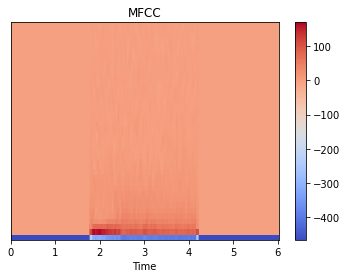

In [36]:
path='/content/processed_audio_files/'

import librosa.display
file=path + Xtrain.iloc[193].filename 
sound,sample_rate= lb.load(file)
mfccs = lb.feature.mfcc(y=sound, sr=sample_rate, n_mfcc=40)
fig, ax = plt.subplots()
img = librosa.display.specshow(mfccs, x_axis='time', ax=ax)
fig.colorbar(img, ax=ax)
ax.set(title='MFCC')

In [40]:
Xtrain.to_csv('train.csv')
Xval.to_csv('val.csv')
ytrain=train.disease
yval=val.disease

In [39]:
train=pd.read_csv('/content/train.csv')
val=pd.read_csv('/content/val.csv')


,Unnamed: 0,pid,filename,disease
0,1444,130,130_1p3_Pr_mc_AKGC417L_2.wav,COPD
1,5915,159,159_1b1_Al_sc_Meditron_10.wav,Healthy
2,473,154,154_2b4_Tc_mc_AKGC417L_0.wav,COPD
3,6347,144,144_1b1_Al_sc_Meditron_7.wav,Healthy
4,1243,130,130_1p3_Pr_mc_AKGC417L_0.wav,COPD


In [45]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
ytrain=le.fit_transform(ytrain)
yval=le.transform(yval)


In [46]:
def getFeatures(path):
    soundArr,sample_rate=lb.load(path)
    mfcc=lb.feature.mfcc(y=soundArr,sr=sample_rate)
    cstft=lb.feature.chroma_stft(y=soundArr,sr=sample_rate)
    mSpec=lb.feature.melspectrogram(y=soundArr,sr=sample_rate)

    return mfcc,cstft,mSpec

In [60]:
root='/content/processed_audio_files/'
mfcc,cstft,mSpec=[],[],[]

for idx,row in val.iterrows():
    path=root + row['filename']
    a,b,c=getFeatures(path)
    mfcc.append(a)
    cstft.append(b)
    mSpec.append(c)
    
mfcc_val=np.array(mfcc)
cstft_val=np.array(cstft)
mSpec_val=np.array(mSpec)

/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


In [63]:
root='/content/processed_audio_files/'
mfcc,cstft,mSpec=[],[],[]

for idx,row in train.iterrows():
    path=root + row['filename']
    a,b,c=getFeatures(path)
    mfcc.append(a)
    cstft.append(b)
    mSpec.append(c)
    #tone.append(d)
    #specCen.append(e)
    
mfcc_train=np.array(mfcc)
cstft_train=np.array(cstft)
mSpec_train=np.array(mSpec)

/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


In [49]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=3, min_lr=0.00001,mode='min')
]

In [50]:
mfcc_input=keras.layers.Input(shape=(20,259,1),name="mfccInput")
x=keras.layers.Conv2D(32,5,strides=(1,3),padding='same')(mfcc_input)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(64,3,strides=(1,2),padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(96,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(128,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
mfcc_output=keras.layers.GlobalMaxPooling2D()(x)

mfcc_model=keras.Model(mfcc_input, mfcc_output, name="mfccModel")

In [52]:
croma_input=keras.layers.Input(shape=(12,259,1),name="cromaInput")
x=keras.layers.Conv2D(32,5,strides=(1,3),padding='same')(croma_input)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(64,3,strides=(1,2),padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(128,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
croma_output=keras.layers.GlobalMaxPooling2D()(x)

croma_model=keras.Model(croma_input, croma_output, name="cromaModel")

In [53]:
mSpec_input=keras.layers.Input(shape=(128,259,1),name="mSpecInput")
x=keras.layers.Conv2D(32,5,strides=(2,3),padding='same')(mSpec_input)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(64,3,strides=(2,2),padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(96,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(128,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
mSpec_output=keras.layers.GlobalMaxPooling2D()(x)

mSpec_model=keras.Model(mSpec_input, mSpec_output, name="mSpecModel")

In [54]:
input_mfcc=keras.layers.Input(shape=(20,259,1),name="mfcc")
mfcc=mfcc_model(input_mfcc)

input_croma=keras.layers.Input(shape=(12,259,1),name="croma")
croma=croma_model(input_croma)

input_mSpec=keras.layers.Input(shape=(128,259,1),name="mspec")
mSpec=mSpec_model(input_mSpec)


concat=keras.layers.concatenate([mfcc,croma,mSpec])
hidden=keras.layers.Dropout(0.2)(concat)
hidden=keras.layers.Dense(50,activation='relu')(concat)
hidden=keras.layers.Dropout(0.3)(hidden)
hidden=keras.layers.Dense(25,activation='relu')(hidden)
hidden=keras.layers.Dropout(0.3)(hidden)
output=keras.layers.Dense(8,activation='softmax')(hidden)

net=keras.Model([input_mfcc,input_croma,input_mSpec], output, name="Net")

In [55]:
from keras import backend as K
net.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
K.set_value(net.optimizer.learning_rate, 0.001)

In [64]:
history=net.fit(
    {"mfcc":mfcc_train,"croma":cstft_train,"mspec":mSpec_train},
    ytrain,
    validation_data=({"mfcc":mfcc_val,"croma":cstft_val,"mspec":mSpec_val},yval),
    epochs=100,verbose=0,
    callbacks=my_callbacks)

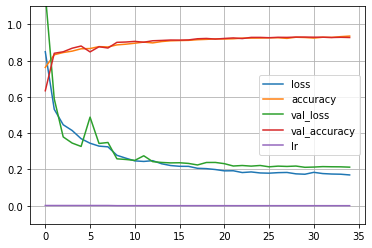

In [67]:

pd.DataFrame(history.history).plot()
plt.grid(True)
plt.gca().set_ylim(-0.1,1.1)
plt.show()

In [68]:
net.evaluate({"mfcc":mfcc_val,"croma":cstft_val,"mspec":mSpec_val},yval)

54/54 [==============================] - 1s 13ms/step - loss: 0.2126 - accuracy: 0.9281


[0.2125527262687683, 0.928115963935852]

In [ ]:
# Define helper functions

# Load a .wav file. 
# These are 24 bit files. The PySoundFile library is able to read 24 bit files.
# https://pysoundfile.readthedocs.io/en/0.9.0/

def get_wav_info(wav_file_2):
    data, rate = sf.read(wav_file_2)
    return data, rate

# source: Andrew Ng Deep Learning Specialization, Course 5
def graph_spectrogram(wav):
    data, rate = get_wav_info(wav)
    nfft = 200 # Length of each window segment
    fs = 8000 # Sampling frequencies
    noverlap = 120 # Overlap between windows
    nchannels = data.ndim
    if nchannels == 1:
        pxx, freqs, bins, im = plt.specgram(data, nfft, fs, noverlap = noverlap)
    elif nchannels == 2:
        pxx, freqs, bins, im = plt.specgram(data[:,0], nfft, fs, noverlap = noverlap)
    return pxx

/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:7592: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


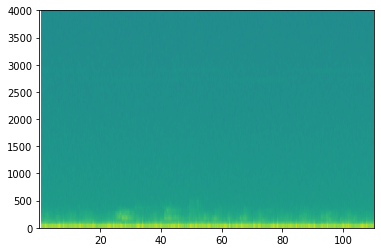

In [ ]:
#Picking out one sound and viewing the spectrogram
path = \
'/content/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files/154_2b4_Al_mc_AKGC417L.wav'
x = graph_spectrogram(path)

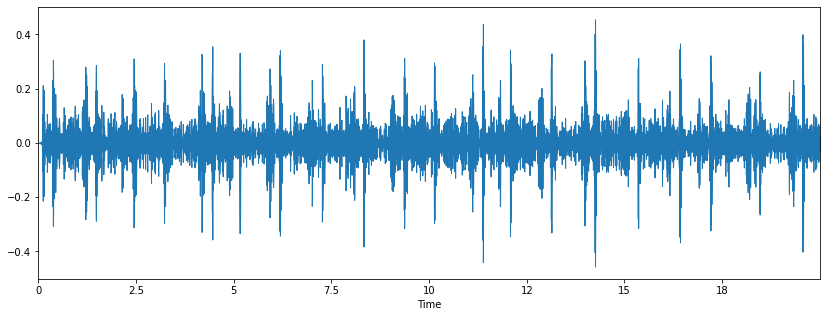

In [ ]:
x, sr = librosa.load(path, sr=200)
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)

Pre Process Sound

In [ ]:
import os
import sys
import glob
from os.path import dirname as up
from tqdm import tqdm
from ipywidgets import widgets, interact
mf_path = '/content/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files/'    # Main Folder Path
sys.path.insert(1, mf_path)
os.chdir(mf_path )



In [ ]:
# Initializing Variables
sound_list = []
sound_reco = []
sf_reco = []
# Loading Loop
for file in tqdm(glob.glob("*.wav")):
    sound_list.append(file)
    # Loading and resampling sounds to 2kHz with librosa is too slow
    data, sfile = sf.read(mf_path  + file)#, sr = 2000)
    sound_reco.append(data)
    sf_reco.append(sfile)
    
print(' -----')
n_sounds = np.shape(sound_list)[0]
print('Number of sound Recordings = ', n_sounds)

100%|██████████| 920/920 [00:02<00:00, 378.42it/s]

 -----
Number of sound Recordings =  920


**Mel Spectogram (MFCC)**

For each audio file in the dataset, we will extract an MFCC (meaning we have an image representation for each audio sample0

In [ ]:
#w = widgets.IntSlider(min=0, max=n_sounds, step = 1, value = 10) (w.value)
X = sound_reco[1]
X = aidt.butter_bp_fil(X, 100, 300, sfile)

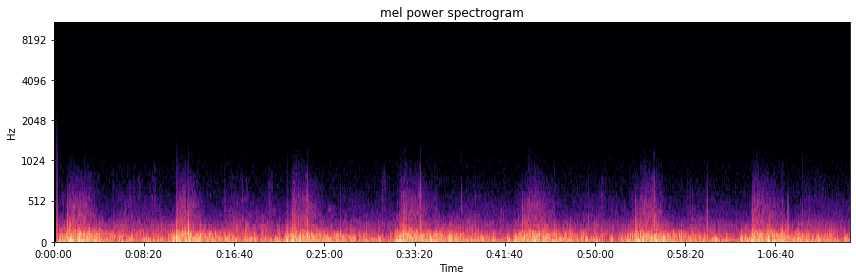

In [ ]:
import librosa.display as lbdis
# Mel spectrogram
Mspec = librosa.feature.melspectrogram(X, sr=sfile, n_mels=128)
# Convert to log scale (dB)
Mspec_db = librosa.power_to_db(Mspec, ref=np.max)
# Plotting Mel Spectrogram
plt.figure(figsize=(12,4))
lbdis.specshow(Mspec_db, sr=sr, x_axis='time', y_axis='mel')
plt.title('mel power spectrogram')
plt.tight_layout()

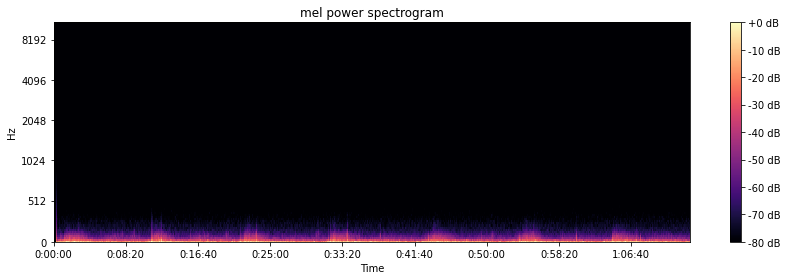

In [ ]:
# Let's make and display a mel-scaled power (energy-squared) spectrogram
S = librosa.feature.melspectrogram(X, sr=sr, n_mels=128)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

# Make a new figure
plt.figure(figsize=(12,4))

# Display the spectrogram on a mel scale
# sample rate and hop length parameters are used to render the time axis
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')

# Put a descriptive title on the plot
plt.title('mel power spectrogram')

# draw a color bar
plt.colorbar(format='%+02.0f dB')

# Make the figure layout compact
plt.tight_layout()


# **[Harmonic-percussive source separation](https://nbviewer.jupyter.org/github/bmcfee/librosa/blob/master/examples/LibROSA%20demo.ipynb)**

In [ ]:
y_harmonic, y_percussive = librosa.effects.hpss(X)

In [ ]:
# What do the spectrograms look like?
# Let's make and display a mel-scaled power (energy-squared) spectrogram
S_harmonic   = librosa.feature.melspectrogram(y_harmonic, sr=sr)
S_percussive = librosa.feature.melspectrogram(y_percussive, sr=sr)

# Convert to log scale (dB). We'll use the peak power as reference.
log_Sh = librosa.power_to_db(S_harmonic, ref=np.max)
log_Sp = librosa.power_to_db(S_percussive, ref=np.max)

# Make a new figure
plt.figure(figsize=(12,6))

plt.subplot(2,1,1)
# Display the spectrogram on a mel scale
librosa.display.specshow(log_Sh, sr=sr, y_axis='mel')

# Put a descriptive title on the plot
plt.title('mel power spectrogram (Harmonic)')

# draw a color bar
plt.colorbar(format='%+02.0f dB')

plt.subplot(2,1,2)
librosa.display.specshow(log_Sp, sr=sr, x_axis='time', y_axis='mel')

# Put a descriptive title on the plot
plt.title('mel power spectrogram (Percussive)')

# draw a color bar
plt.colorbar(format='%+02.0f dB')

# Make the figure layout compact
plt.tight_layout()



Needed Libraries
---



In [ ]:
import os
import sys
from os.path import dirname as up

In [ ]:
mf_path = (up(os.getcwd())).replace('\\','/')    # Main Folder Path
sys.path.insert(1, mf_path)
os.chdir('/Respiratory_Sound_Database/audio_and_txt_files')
lp = mf_path + '/aidiagnostics_labels.csv'
lbs = pd.read_csv(lp)                 #  Labels 
sn = np.array(lbs.columns.values)     #  Names of recordings labelled

print('sound labelled: ', sn[0])